In [14]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
device='cpu'
classes={1:'fire',2:'smoke'}

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

WEIGHTS_FILE = r"D:\nn\code\ckpt\faster_rcnn_state_2.pth"

num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location='cpu'))

model.to(device)

model.eval()

image = torch.rand([1, 3, 416, 416])


torch.onnx.export(model, (image,), 'faster_rcnn.onnx',opset_version = 11)

d:\Programs\miniconda3\lib\site-packages\torch\nn\functional.py:3896: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
d:\Programs\miniconda3\lib\site-packages\torchvision\models\detection\anchor_utils.py:121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  torch.empty((), dtype=torch.int64, device=device).fill_(image_size[0] // g[0]),
d:\Programs\miniconda3\lib\site-packages\torchvision\models\detection\anchor_u

In [15]:
import onnxruntime as ort
import numpy as np
 
class Onnx_Module(ort.InferenceSession):
    ''' onnx 推理模型
        provider: 优先使用 GPU'''
    provider = ort.get_available_providers()[
        1 if ort.get_device() == 'GPU' else 0]
 
    def __init__(self, file):
        super(Onnx_Module, self).__init__(file, providers=[self.provider])
        # 参考: ort.NodeArg
        self.inputs = [node_arg.name for node_arg in self.get_inputs()]
        self.outputs = [node_arg.name for node_arg in self.get_outputs()]
 
    def __call__(self, *arrays):
        input_feed = {name: x for name, x in zip(self.inputs, arrays)}
        return self.run(self.outputs, input_feed)

In [29]:
import numpy as np
 

model = Onnx_Module('faster_rcnn.onnx')
 

imgpath=r'D:\nn\code\datasets\fire\fire\test\20230322101540.jpg'
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
img=cv2.resize(img,(416,416))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


img /= 255.0
img = torch.from_numpy(img)
img = img.unsqueeze(0)
img = img.permute(0,3,1,2).numpy()

res=model(img)
print(res)

[array([[109.715126, 184.7318  , 187.87718 , 322.3367  ],
       [108.01832 , 179.36623 , 122.37654 , 313.58572 ]], dtype=float32), array([1, 1], dtype=int64), array([0.9905815 , 0.19179896], dtype=float32)]


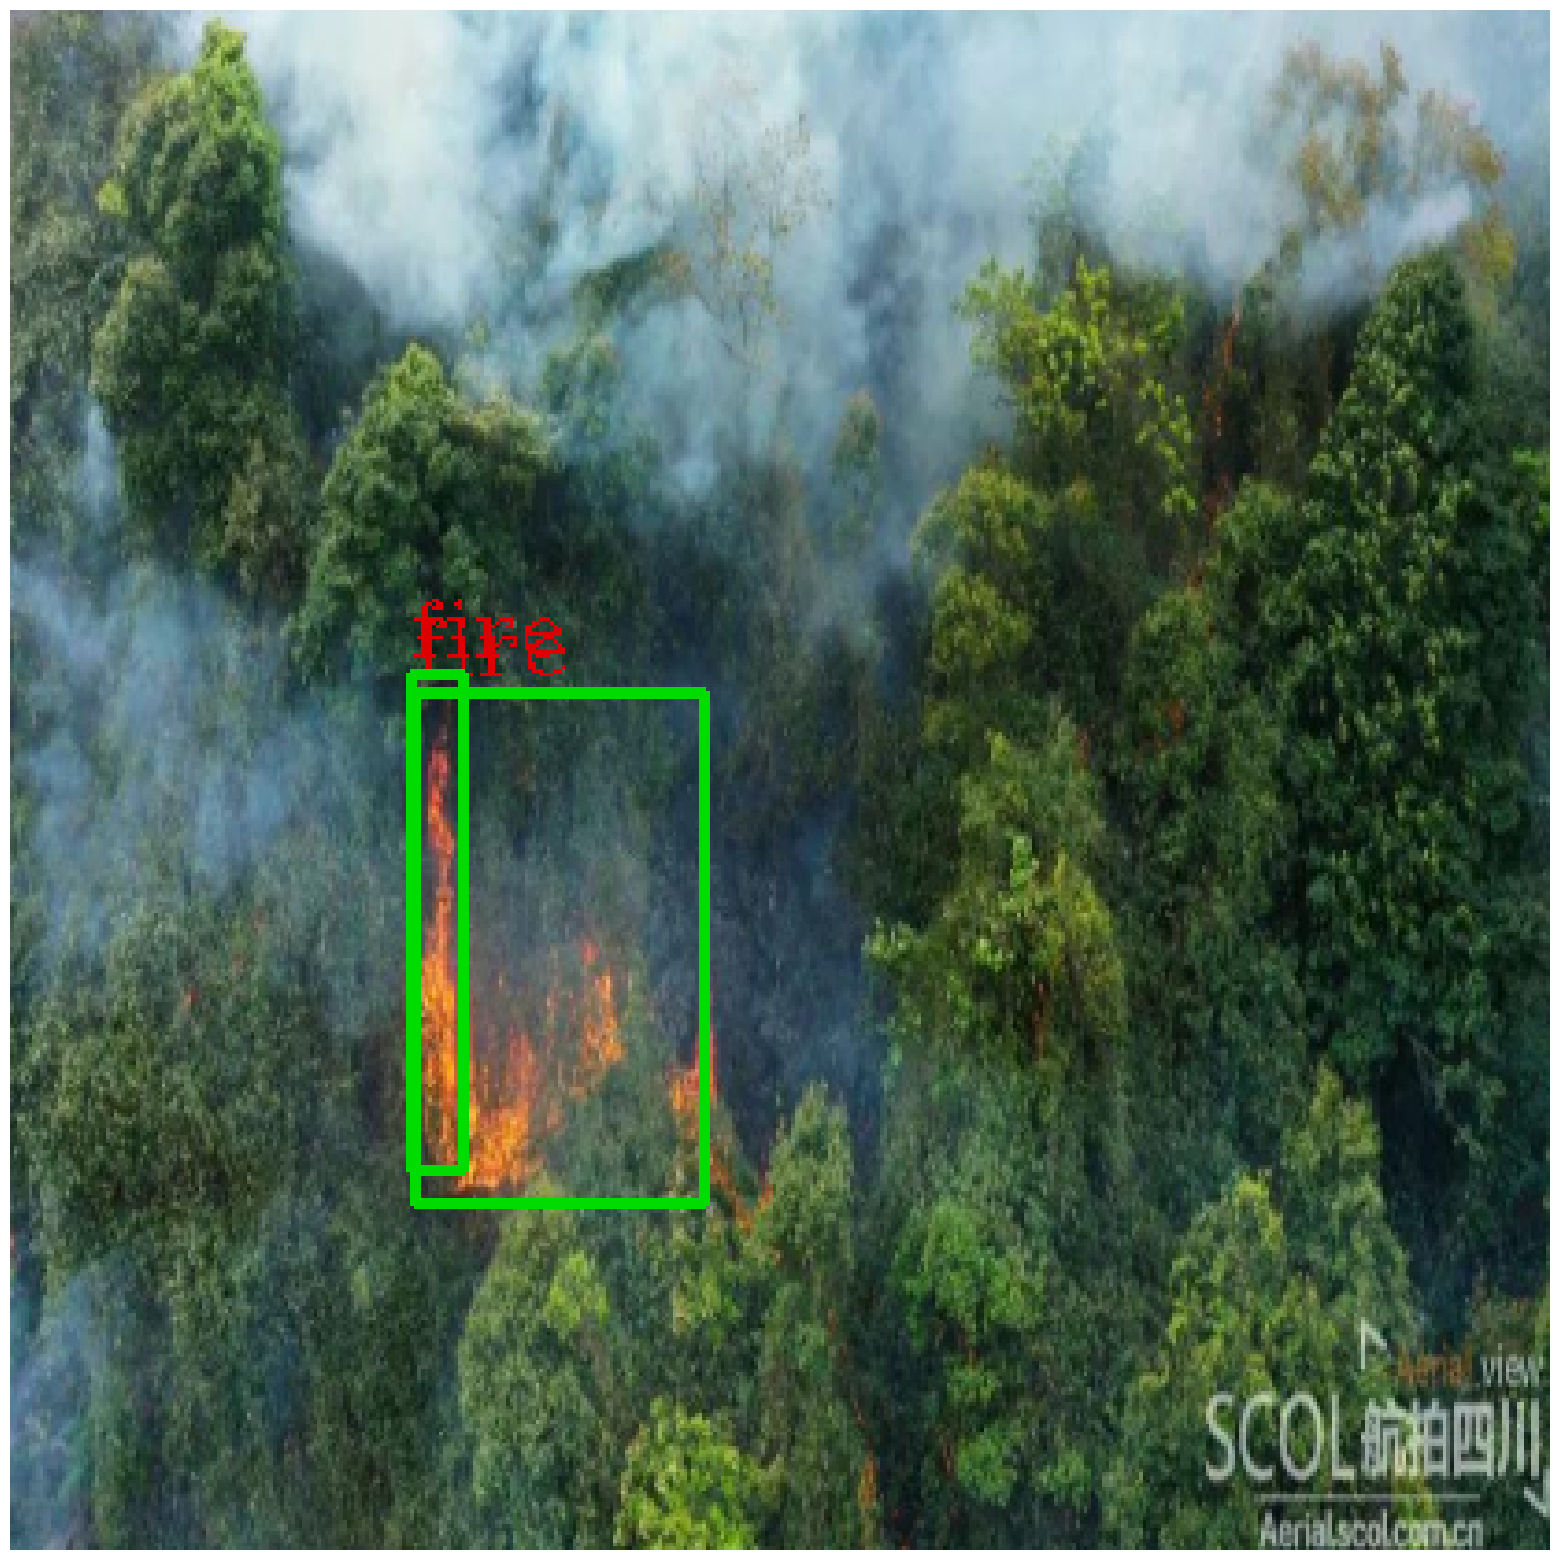

In [43]:
plt.figure(figsize=(20,20))
classes={1:'fire',2:'smoke'}
sample = cv2.imread(imgpath, cv2.IMREAD_COLOR)
sample=cv2.resize(sample,(416,416))
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB).astype(np.int32)

boxs,names,scores = res
boxs=boxs.astype(np.int32)
for i,box in enumerate(boxs):
    cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 220, 0), 2)
    cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

plt.axis('off')
plt.imshow(sample)